# ideas

- Have it create 3 objects that represent all the songs. 
- Get the general vibe
- Feed to Flux replicate

## prompts

"Give me a prompt that will be able represent this playlist in a latent diffusion model. Make it minimalist and abstract. If relevant, incorporate imagery that relates to the specific songs or artists"


In [40]:
import requests
import base64
import json
import os
from statistics import mean
import os
import anthropic
import base64
import re
import sys
from io import StringIO
import ast
import glob 
import shutil
import datetime
import json
from anthropic import Anthropic
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image, ImageDraw
import io
import replicate
from IPython.display import Image, display
import requests


# Setup

## Claude

In [41]:
api_key = os.environ.get("ANTHROPIC_API_KEY_SPOTIFY")
if not api_key:
    print("Error: ANTHROPIC_API_KEY environment variable is not set.")
    exit(1)

# Set up the client
client = anthropic.Anthropic(api_key=api_key)

In [42]:
def get_conversation(prompt):
    message = [{
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt,
                        }
                    ]
                }]
    return message

In [43]:
# claude-3-haiku-20240307
# claude-3-5-sonnet-20240620
def send_message(conversation):
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=1024,
        messages=conversation
    )
    # print(f"response to followup: {message.content}")
    pure_text = message.content[0].text
    # print(f"pure text: {pure_text}")
    return pure_text

In [44]:
def extract_description(text):
    start = text.index('[') + 1
    end = text.index(']')
    result = text[start:end]
    return result
print(extract_description("The image is a photo[graph hello world] test test"))

graph hello world


In [49]:
test_convo = get_conversation("Hey Claude!")
print(send_message(test_convo))

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'Your credit balance is too low to access the Claude API. Please go to Plans & Billing to upgrade or purchase credits.'}}

## Spotify

In [50]:
# Replace these with your actual Client ID and Client Secret
CLIENT_ID = os.environ.get('SPOTIFY_CLIENT_ID')
CLIENT_SECRET = os.environ.get('SPOTIFY_CLIENT_SECRET')

client_creds = f"{CLIENT_ID}:{CLIENT_SECRET}"
client_creds_b64 = base64.b64encode(client_creds.encode())

# Token URL
token_url = 'https://accounts.spotify.com/api/token'

# Request Body Parameters
token_data = {
    'grant_type': 'client_credentials'
}

# Request Headers
token_headers = {
    'Authorization': f'Basic {client_creds_b64.decode()}'
}

### Single song

In [52]:
r = requests.post(token_url, data=token_data, headers=token_headers)

if r.status_code == 200:
    print("Authentication successful!")
    token = r.json()['access_token']
    
    # Now let's try to get info about a track
    track_id = '11dFghVXANMlKmJXsNCbNl'  # This is the Spotify ID for "Cut To The Feeling" by Carly Rae Jepsen
    track_url = f'https://api.spotify.com/v1/tracks/{track_id}'
    
    track_headers = {
        'Authorization': f'Bearer {token}'
    }
    
    track_response = requests.get(track_url, headers=track_headers)
    
    if track_response.status_code == 200:
        track_data = track_response.json()
        print(f"Successfully retrieved data for the track: {track_data['name']} by {track_data['artists'][0]['name']}")
    else:
        print(f"Failed to retrieve track data. Status code: {track_response.status_code}")
        print(f"Error message: {track_response.text}")
else:
    print(f"Authentication failed. Status code: {r.status_code}")
    print(f"Error message: {r.text}")

Authentication successful!
Successfully retrieved data for the track: Cut To The Feeling by Carly Rae Jepsen


### Playlist details

In [51]:
# Authentication
def get_token():
    auth_string = f"{CLIENT_ID}:{CLIENT_SECRET}"
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = requests.post(url, headers=headers, data=data)
    json_result = result.json()
    token = json_result["access_token"]
    return token

def get_auth_header(token):
    return {"Authorization": "Bearer " + token}

# Get playlist tracks
def get_playlist_tracks(token, playlist_id):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = get_auth_header(token)
    
    tracks = []
    while url:
        result = requests.get(url, headers=headers)
        json_result = result.json()
        
        for item in json_result['items']:
            track = item['track']
            tracks.append({
                'id': track['id'],
                'name': track['name'],
                'artist': track['artists'][0]['name']
            })
        
        url = json_result.get('next')  # Get the next page URL, if it exists

    return tracks

# Get audio features for tracks
def get_audio_features(token, track_ids):
    url = f"https://api.spotify.com/v1/audio-features"
    headers = get_auth_header(token)
    params = {'ids': ','.join(track_ids)}
    
    result = requests.get(url, headers=headers, params=params)
    return result.json()['audio_features']

# Analyze vibe based on audio features
def analyze_vibe(features):
    valence = features['valence']
    energy = features['energy']
    danceability = features['danceability']
    tempo = features['tempo']
    
    vibe = []
    if valence > 0.6:
        vibe.append("positive")
    elif valence < 0.4:
        vibe.append("melancholic")
    
    if energy > 0.7:
        vibe.append("energetic")
    elif energy < 0.3:
        vibe.append("calm")
    
    if danceability > 0.7:
        vibe.append("danceable")
    
    if tempo > 120:
        vibe.append("upbeat")
    elif tempo < 80:
        vibe.append("slow")
    
    return ", ".join(vibe) if vibe else "neutral"


In [53]:
def get_playlist_details(PLAYLIST_ID):
    token = get_token()
    tracks = get_playlist_tracks(token, PLAYLIST_ID)

    # Get audio features for all tracks
    track_ids = [track['id'] for track in tracks]
    # print(f"token: {token}, track_ids: {track_ids}")
    audio_features = get_audio_features(token, track_ids)

    # Calculate averages
    avg_valence = mean(feature['valence'] for feature in audio_features)
    avg_energy = mean(feature['energy'] for feature in audio_features)

    # print(f"Tracks in the playlist (total: {len(tracks)}):")
    playlist_description = ""

    for i, (track, features) in enumerate(zip(tracks, audio_features), 1):
        vibe = analyze_vibe(features)
        playlist_description += f"{i}. {track['name']} by {track['artist']}\n"
        playlist_description += f"   Vibe: {vibe}\n"
        playlist_description += f"   Valence: {features['valence']:.2f}, Energy: {features['energy']:.2f}\n\n"

    playlist_description += f"Playlist Averages:\n"
    playlist_description += f"Average Valence: {avg_valence:.2f}\n"
    playlist_description += f"Average Energy: {avg_energy:.2f}\n\n"

    # Analyze overall playlist vibe
    playlist_vibe = []
    if avg_valence > 0.6:
        playlist_vibe.append("positive")
    elif avg_valence < 0.4:
        playlist_vibe.append("melancholic")
    else:
        playlist_vibe.append("mix of positive and melancholic")

    if avg_energy > 0.7:
        playlist_vibe.append("high-energy")
    elif avg_energy < 0.3:
        playlist_vibe.append("low-energy")
    else:
        playlist_vibe.append("moderate energy")

    playlist_description += f"Overall Playlist Vibe: {', '.join(playlist_vibe)}"

    # Print the entire playlist description
    return playlist_description

In [54]:
# https://open.spotify.com/playlist/7tZrkSzitYTgiY4p8qTseT?si=fffc72bfe8704c54
ethan_calm_old = "08KlCLIoGvtSm1NpB6aO67"
ethan_electronic_ambient = "7tZrkSzitYTgiY4p8qTseT"
print(get_playlist_details(ethan_calm_old))

1. Be Ever Wonderful by Ted Taylor
   Vibe: melancholic
   Valence: 0.19, Energy: 0.38

2. My Mood Is You by Freddy Cole
   Vibe: melancholic, calm
   Valence: 0.12, Energy: 0.10

3. The End of the World by Skeeter Davis
   Vibe: calm
   Valence: 0.43, Energy: 0.22

4. The Three Bells (Les Trois Cloches) (feat. Jim Ed Brown) by The Browns
   Vibe: melancholic
   Valence: 0.32, Energy: 0.33

5. Again (with The Mellomen) by Doris Day
   Vibe: melancholic, calm, slow
   Valence: 0.15, Energy: 0.02

6. When I Fall In Love by The Lettermen
   Vibe: melancholic, calm
   Valence: 0.21, Energy: 0.27

7. Sara Smile by Daryl Hall & John Oates
   Vibe: melancholic, upbeat
   Valence: 0.20, Energy: 0.40

8. Our Prayer by The Beach Boys
   Vibe: melancholic, calm
   Valence: 0.21, Energy: 0.05

9. Surfer Girl - Remastered 2001 by The Beach Boys
   Vibe: positive
   Valence: 0.65, Energy: 0.37

10. Let's Stay Together by Al Green
   Vibe: danceable
   Valence: 0.51, Energy: 0.40

11. All I Wanna Do 

# Main

cool awesome image that's abstract and minimalist
['https://replicate.delivery/yhqm/0ZHPRFDmsm4uP95xlut8uyFARgz2yiCA5JPczwHvFeJaqBtJA/out-0.webp']


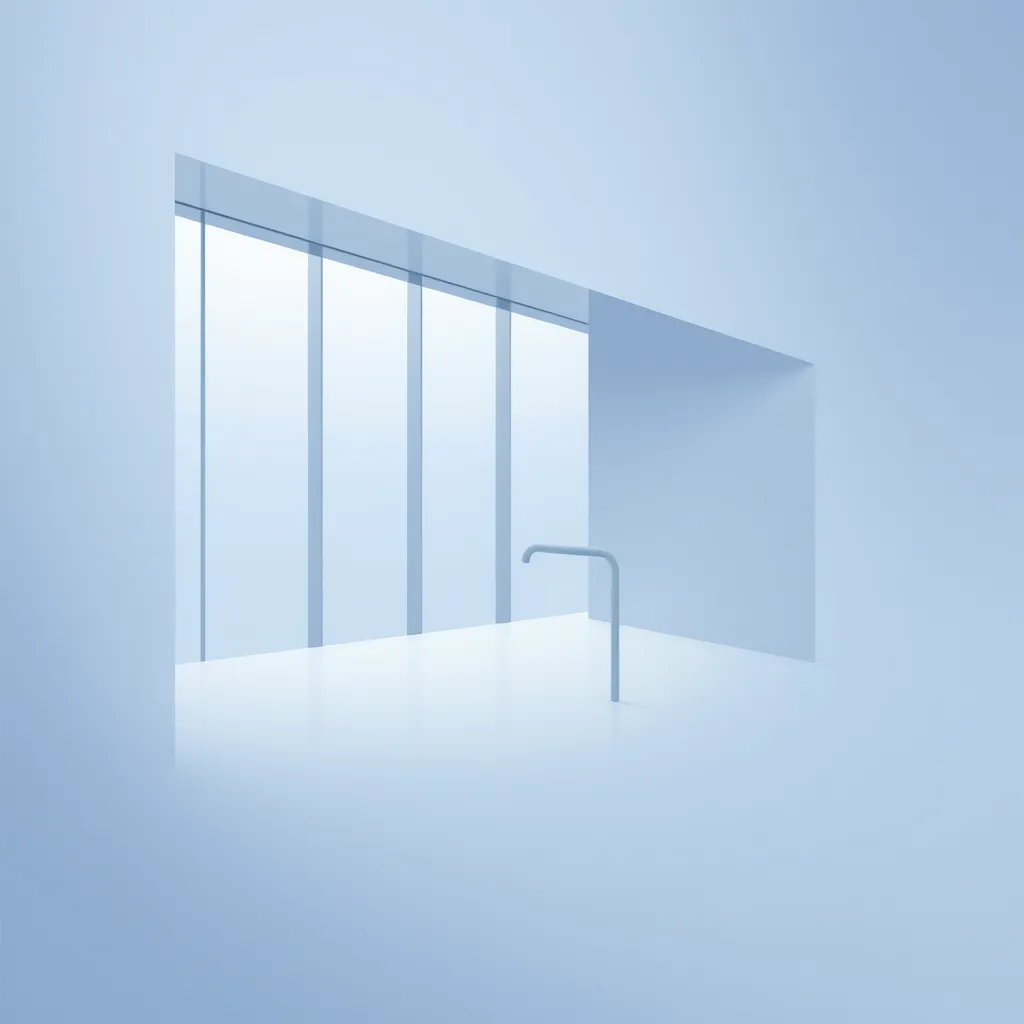

In [56]:
# https://open.spotify.com/playlist/71vvwEbxgXqHZ7ONA6WGxt?si=65e01d855e454962
bossa = '6cGZkPs8wimEZBDzpVNaut'
jazz = '71vvwEbxgXqHZ7ONA6WGxt'
PLAYLIST_ID = '2djCZlngGykIYIvhRtPq39'
playlist_description = get_playlist_details(ethan_electronic_ambient)
prompt = f"""Give me a prompt that will be able represent this playlist in a latent diffusion model. Make it minimalist and abstract but still keep it interesting. I don't want hotel art level minimalism, I want something raw and artistic. If relevant, incorporate imagery that relates to the specific songs or artists. Put your description in square brackets like this [description].\n\n

{playlist_description}"""

convo = get_conversation(prompt)
# response = send_message(convo)

description = "cool awesome image that's abstract and minimalist"
# description = extract_description(response)
print(description)
output = replicate.run(
    "black-forest-labs/flux-schnell",
    input={
        "prompt": description,
        "num_outputs": 1,
        "aspect_ratio": "1:1",
        "output_format": "webp",
        "output_quality": 80
    }
)
print(output)
image_url = output[0]

# Download the image
response = requests.get(image_url)
image_data = response.content

# Display the image
display(Image(image_data))


## get all playlists

In [16]:
CLIENT_ID = os.environ.get('SPOTIFY_CLIENT_ID')
CLIENT_SECRET = os.environ.get('SPOTIFY_CLIENT_SECRET')

In [18]:
import requests
import urllib.parse
import secrets
from IPython.display import IFrame

# Spotify API credentials

REDIRECT_URI = 'http://localhost:8888/callback'

def get_auth_url():
    state = secrets.token_hex(8)
    scope = 'user-read-private user-read-email playlist-read-private'
    
    params = {
        'response_type': 'code',
        'client_id': CLIENT_ID,
        'scope': scope,
        'redirect_uri': REDIRECT_URI,
        'state': state
    }
    
    auth_url = 'https://accounts.spotify.com/authorize?' + urllib.parse.urlencode(params)
    return auth_url

def get_tokens(code):
    token_url = 'https://accounts.spotify.com/api/token'
    
    payload = {
        'grant_type': 'authorization_code',
        'code': code,
        'redirect_uri': REDIRECT_URI,
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET
    }
    
    response = requests.post(token_url, data=payload)
    return response.json()

# Get the authorization URL
auth_url = get_auth_url()
print("Please visit this URL to authorize the application:")
print(auth_url)

# Display the authorization page in the notebook
IFrame(auth_url, width=800, height=600)

# After authorization, you'll be redirected to a URL like:
# http://localhost:8888/callback?code=AQD...&state=...

# Prompt for the full redirect URL
redirect_url = input("Please enter the full URL you were redirected to: ")

# Extract the code from the URL
code = urllib.parse.parse_qs(urllib.parse.urlparse(redirect_url).query)['code'][0]

# Exchange the code for tokens
tokens = get_tokens(code)

print("Access Token:", tokens.get('access_token'))
print("Refresh Token:", tokens.get('refresh_token'))

# Now you can use the access token to make requests to the Spotify API

Please visit this URL to authorize the application:
https://accounts.spotify.com/authorize?response_type=code&client_id=1509513843f341bea276837d47c7a0de&scope=user-read-private+user-read-email+playlist-read-private&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2Fcallback&state=d4007f7981fb0ca9
Access Token: BQCHTAnqAeSqw8rwkoPIw4LYpld0BYLGX0P0kRQGEo7ExxBdAsszhLd6WzVdTxq8EigsVjRljF5BiKXir7nQFwJBU1DJij8XHcG3yzFtarfH_5ZhnvwoWuB4RAhsORC3xHA0mN7E0A5oPlmwIqyLhX6B4JXhlBtvEtd4W3VhHkZ62FIg8Ik9x1vK7jWyP_d3Cq5Q7r7TiCXRrl-lc3jA
Refresh Token: AQARb6hVbzZpbcUAYmf4KLPim_CFmR3rBnwvO4EZ_UPBNAsuMOXFj1QL1A85iyXUBi8aeCH1q3Au3iv_o0tZFmj0ZQDn-dfxbvQDtSwhgufFcFQQDmq6TWDMoLYRYW5a_-Y


In [19]:
headers = {
    'Authorization': f'Bearer {tokens["access_token"]}',
}

response = requests.get('https://api.spotify.com/v1/me/playlists', headers=headers)
playlists = response.json()

for playlist in playlists['items']:
    print(playlist['name'])

Release Radar
🍄🍄
UNRELEASED YOUNG THUG
listen to later
AL Blue
Analog 4 - (Shoegazy)
Black Yacht Rock
🦇🏠
Jamaica Beach
Orange silK
Jazzington Station
Reggae
Playboi Carti Leaks (MUSIC)
Dextroamphetamine
Special K
Yacht Rock (2)
Shroom 2
git add .
Don’t scare the hoes edm
Analog 3
Yacht Rock
DJ
Commit Push
Horse Tranquilizer
X-TATIC
max volume
Music For Dad
Zoloft Pack
judsonlisenby + septitunes
old HOUSE
21st!!
Analog 2
sboltonmd
Ambient House
Party
Real RX
Gritty sounds 
My Playlist #112
Art of PR 🔱
Tren Dreams 🛌 
Group Crew Boys Mix
Lean4Real
Mid Girl Summer 🏝🏝
Sigs Inside
Creatine Dreams
👾
Man in Black
Opium
trap House
Methylphenidate Pack
